In [2]:
from tensorflow.keras.layers import Input,Dense,SimpleRNN, GRU,LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#make the original data
series = np.sin((0.1 * np.arange(400))**2)

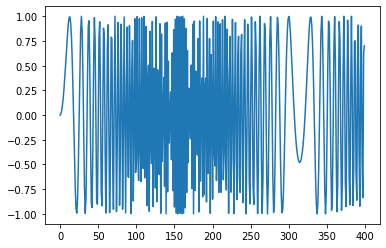

In [5]:
#plot it
plt.plot(series)
plt.show()

In [7]:
###build the dataset
#Let's see if we can use T past values to predict the next value
T = 10
D = 1
X =[]
Y = []

for t in range(len(series) - T):
  x =series[t:t+T]
  X.append(x)
  y =series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T) #make it N x T
Y= np.array(Y)
N = len(X)
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (390, 10) Y.shape (390,)


In [12]:
### Try autoregressive linear model
i =Input(shape =(T,))
x = Dense(1)(i)
model =Model(i,x)
model.compile(
    loss ='mse',optimizer =Adam(lr=0.1)
)
#train the RNN
r =model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=800,
    validation_data = (X[-N//2:], Y[-N//2:])
)

Epoch 1/800
7/7 [==============================] - 0s 13ms/step - loss: 0.9695 - val_loss: 0.6247
Epoch 2/800
7/7 [==============================] - 0s 4ms/step - loss: 0.5894 - val_loss: 0.5439
Epoch 3/800
7/7 [==============================] - 0s 4ms/step - loss: 0.5871 - val_loss: 0.6021
Epoch 4/800
7/7 [==============================] - 0s 4ms/step - loss: 0.5568 - val_loss: 0.6628
Epoch 5/800
7/7 [==============================] - 0s 4ms/step - loss: 0.5199 - val_loss: 0.6396
Epoch 6/800
7/7 [==============================] - 0s 4ms/step - loss: 0.5513 - val_loss: 0.5871
Epoch 7/800
7/7 [==============================] - 0s 4ms/step - loss: 0.5572 - val_loss: 0.6656
Epoch 8/800
7/7 [==============================] - 0s 4ms/step - loss: 0.6046 - val_loss: 0.7419
Epoch 9/800
7/7 [==============================] - 0s 4ms/step - loss: 0.5466 - val_loss: 0.5965
Epoch 10/800
7/7 [==============================] - 0s 4ms/step - loss: 0.5121 - val_loss: 0.6296
Epoch 11/800
7/7 [==========

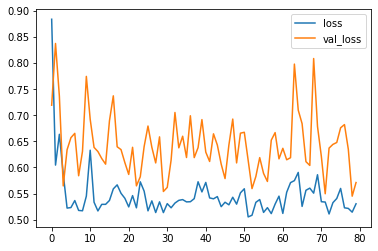

In [11]:
#Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(390, 1)


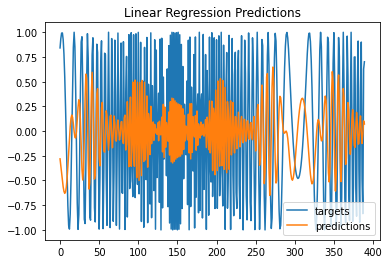

In [14]:
#One-step forecast using true targets
#Note: even the one-step forecast fails badly
outputs = model.predict(X)
print(outputs.shape)
predictions =outputs[:,0]

plt.plot(Y, label = 'targets')
plt.plot(predictions, label= 'predictions')
plt.title('Linear Regression Predictions')
plt.legend()
plt.show()

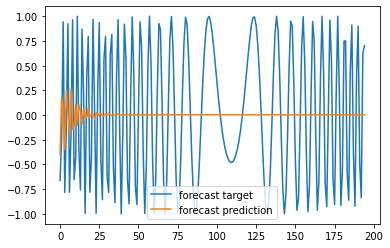

In [15]:
#Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

#last train input
last_x = X[-N//2] #1-D array of length T

while len(validation_predictions) <len(validation_target):
  p =model.predict(last_x.reshape(1,-1))[0,0] # 1x1 array ->scalar
  #update the predictions list
  validation_predictions.append(p)

  #make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast prediction')
plt.legend()


In [27]:
###Now try RNN/LSTM model
X = X.reshape(-1,T, 1) #make it N x D x T

#make the RNN
i = Input(shape = (T,D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(
    loss = 'mse',
    optimizer = Adam(learning_rate=0.05)
)

#train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    batch_size = 32,
    epochs= 200,
    validation_data =(X[-N//2:], Y[-N//2:]),

)

Epoch 1/200
7/7 [==============================] - 0s 61ms/step - loss: 0.5401 - val_loss: 0.5469
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.4926 - val_loss: 0.6391
Epoch 3/200
7/7 [==============================] - 0s 7ms/step - loss: 0.4804 - val_loss: 0.6140
Epoch 4/200
7/7 [==============================] - 0s 7ms/step - loss: 0.4006 - val_loss: 0.4637
Epoch 5/200
7/7 [==============================] - 0s 7ms/step - loss: 0.2963 - val_loss: 0.3828
Epoch 6/200
7/7 [==============================] - 0s 7ms/step - loss: 0.1975 - val_loss: 0.2549
Epoch 7/200
7/7 [==============================] - 0s 7ms/step - loss: 0.1342 - val_loss: 0.1662
Epoch 8/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0654 - val_loss: 0.1150
Epoch 9/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0787 - val_loss: 0.1391
Epoch 10/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0902 - val_loss: 0.0860
Epoch 11/200
7/7 [==========

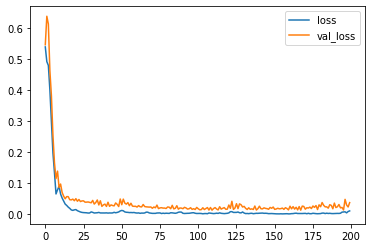

In [28]:
#plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(390, 1)


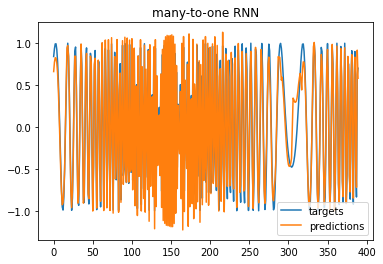

In [29]:
#One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label ='targets')
plt.plot(predictions, label = 'predictions')
plt.title('many-to-one RNN')
plt.legend()
plt.show()

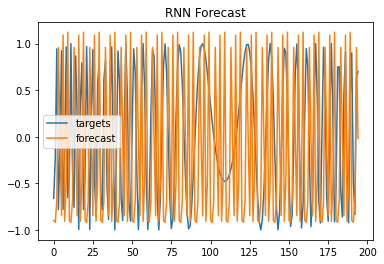

In [30]:
#Multi-step Forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  #Reshape the input_ to  N x T x D
  f = model.predict(input_.reshape(1,T,1 ))[0,0]
  forecast.append(f)
  
  #Make a new input with the latest forecast
  input_  = np.roll(input_,-1)

plt.plot(Y[-N//2:], label = 'targets')
plt.plot(forecast, label = 'forecast')
plt.title('RNN Forecast')
plt.legend()
plt.show()